In [ ]:
!pip install --upgrade xee rioxarray cartopy

In [ ]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import xarray
import rioxarray  # For CRS handling
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [136]:
import ee

# Trigger the authentication flow.
ee.Authenticate()


True

In [137]:
# Initialize the library.
ee.Initialize(project="pyregence-ee", opt_url="https://earthengine-highvolume.googleapis.com")

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
terra_climate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
wrf_variable = ee.ImageCollection(f"projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}").filterDate(f"{start_year}-01-01", f"{end_year}-12-31")


In [181]:
aet = terra_climate.filterDate(f"{start_year}-01-01", f"{end_year}-12-31").select("aet")
aet = ee.ImageCollection(ee.List.sequence(start_year, end_year).map(
    lambda year: aet.filterDate(
        ee.Date.fromYMD(year, 1, 1),
        ee.Date.fromYMD(ee.Number(year).add(1), 1, 1)
    ).mean().set("system:time_start", ee.Date.fromYMD(year, 1, 1).millis())
))


In [182]:
pet = terra_climate.filterDate(f"{start_year}-01-01", f"{end_year}-12-31").select("pet")
pet = ee.ImageCollection(ee.List.sequence(start_year, end_year).map(
    lambda year: pet.filterDate(
        ee.Date.fromYMD(year, 1, 1),
        ee.Date.fromYMD(ee.Number(year).add(1), 1, 1)
    ).mean().set("system:time_start", ee.Date.fromYMD(year, 1, 1).millis())
))


In [184]:
# AET
ds_aet = xarray.open_dataset(aet, crs='EPSG:4326', engine='ee', scale=0.2,geometry=wrf_variable.first().geometry())
aet_mean = ds_aet.mean(dim='time')  # Average AET image

# PET
ds_pet = xarray.open_dataset(pet, crs='EPSG:4326', engine='ee', scale=0.2,geometry=wrf_variable.first().geometry())
pet_mean = ds_pet.mean(dim='time')  # Average PET image


In [145]:
# Instead of reading from a local shapefile, use the Earth Engine asset
poisson_point_ee = ee.FeatureCollection("projects/pyregence-ee/assets/poisson-points/CA_1km_k100_r5_3")


In [146]:
start_year, end_year

(1990, 2023)

In [175]:
# Define the image collection for relative humidity
wrf_variable_name = 'relative-humidity'
wrf_variable = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')
ds_wrf = xarray.open_dataset(wrf_variable, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())

# Calculate the mean over the 'time' dimension
wrf_mean = ds_wrf.mean(dim='time')


In [ ]:

# Extract the mean data for each variable as DataArray
wrf_mean = ds_wrf['B0'].rio.write_crs("EPSG:4326")
aet_mean = ds_aet['aet'].rio.write_crs("EPSG:4326")
pet_mean = ds_pet['pet'].rio.write_crs("EPSG:4326")

# Now compute the correlation between WRF (RH) mean and AET mean
corr_wrf_aet = xarray.corr(wrf_mean, aet_mean, dim='time')

# Compute the correlation between WRF (RH) mean and PET mean
corr_wrf_pet = xarray.corr(wrf_mean, pet_mean, dim='time')




# Average

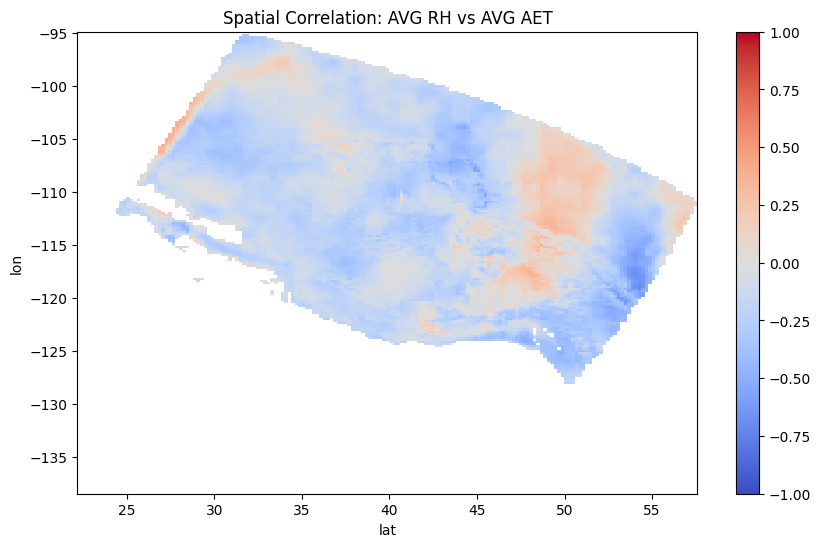

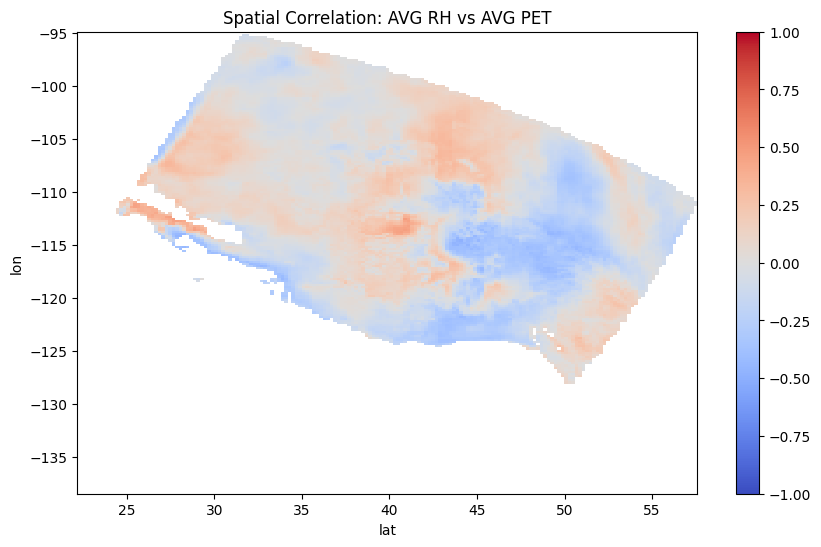

In [187]:

# Plot the correlation maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_wrf_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG RH vs AVG AET")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_wrf_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG RH vs AVG PET")
plt.show()

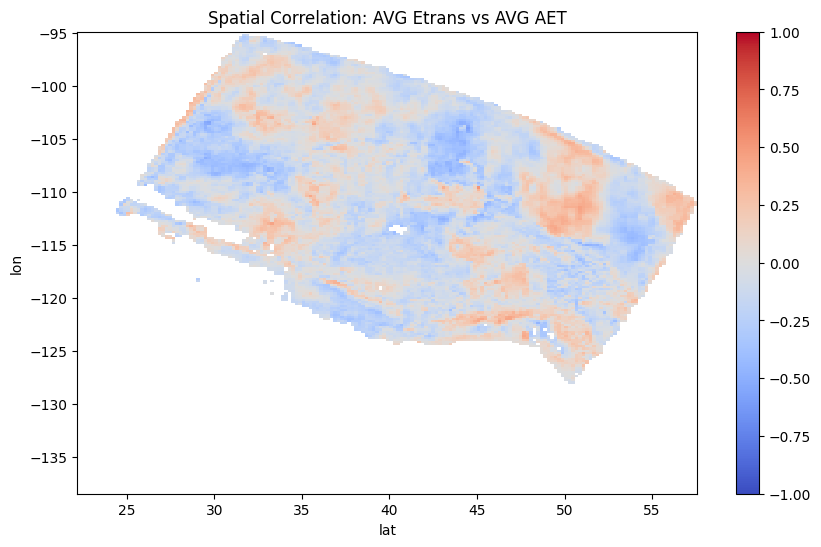

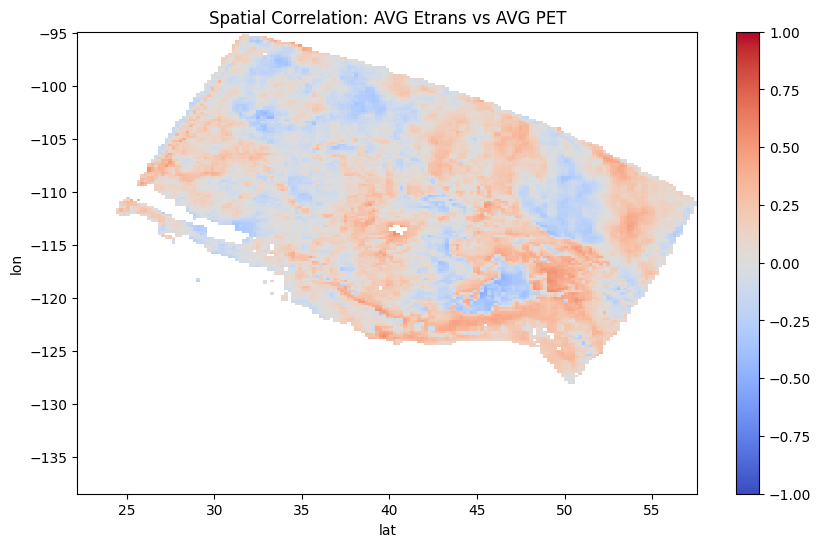

In [189]:
# Define the WRF variable (evapotranspiration at surface)
wrf_variable_name = 'wrf-data-etrans-sfc'
wrf_variable = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Convert to Xarray and calculate the mean over the 'time' dimension
ds_wrf_etrans = xarray.open_dataset(wrf_variable, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())
etrans_mean = ds_wrf_etrans.mean(dim='time')
etrans_mean = ds_wrf_etrans['B0'].rio.write_crs("EPSG:4326")

# Compute the correlation between evapotranspiration (etrans_sfc) mean and AET mean
corr_etrans_aet = xarray.corr(etrans_mean, aet_mean, dim='time')

# Compute the correlation between evapotranspiration (etrans_sfc) mean and PET mean
corr_etrans_pet = xarray.corr(etrans_mean, pet_mean, dim='time')

# Plot the correlation maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_etrans_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG Etrans vs AVG AET")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_etrans_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG Etrans vs AVG PET")
plt.show()


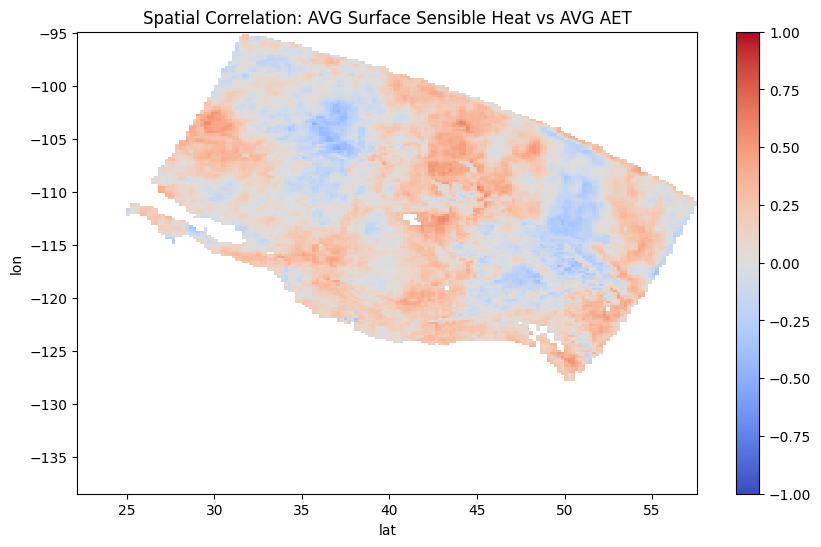

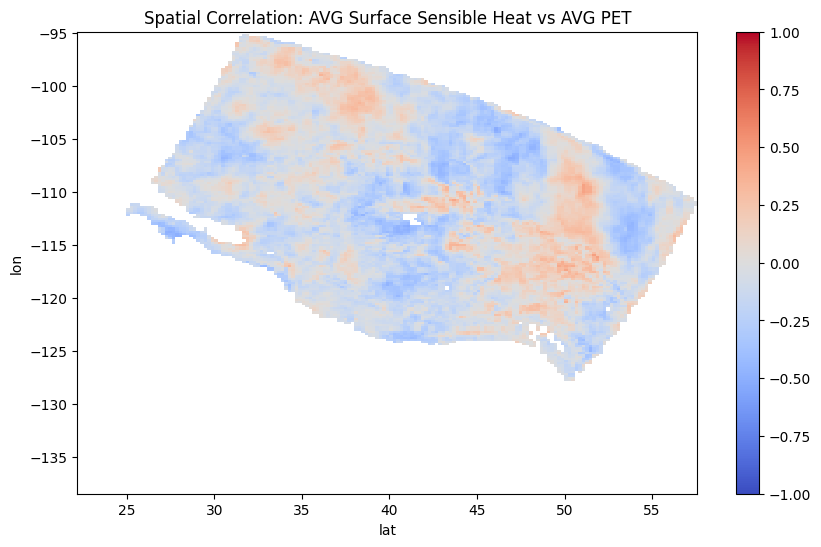

In [190]:
# Define the WRF variable (surface sensible heat)
wrf_variable_name = 'surface-sensible-heat'
wrf_variable = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Convert to Xarray and calculate the mean over the 'time' dimension
ds_wrf_sh = xarray.open_dataset(wrf_variable, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())
sh_mean = ds_wrf_sh.mean(dim='time')
sh_mean = ds_wrf_sh['B0'].rio.write_crs("EPSG:4326")  # Assuming the variable is in 'B0'

# Compute the correlation between surface sensible heat mean and AET mean
corr_sh_aet = xarray.corr(sh_mean, aet_mean, dim='time')

# Compute the correlation between surface sensible heat mean and PET mean
corr_sh_pet = xarray.corr(sh_mean, pet_mean, dim='time')

# Plot the correlation maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_sh_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG Surface Sensible Heat vs AVG AET")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_sh_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: AVG Surface Sensible Heat vs AVG PET")
plt.show()


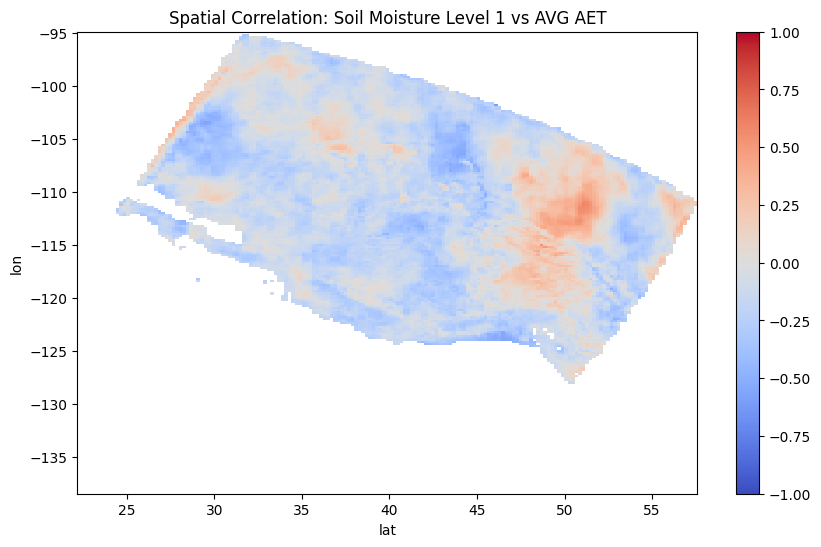

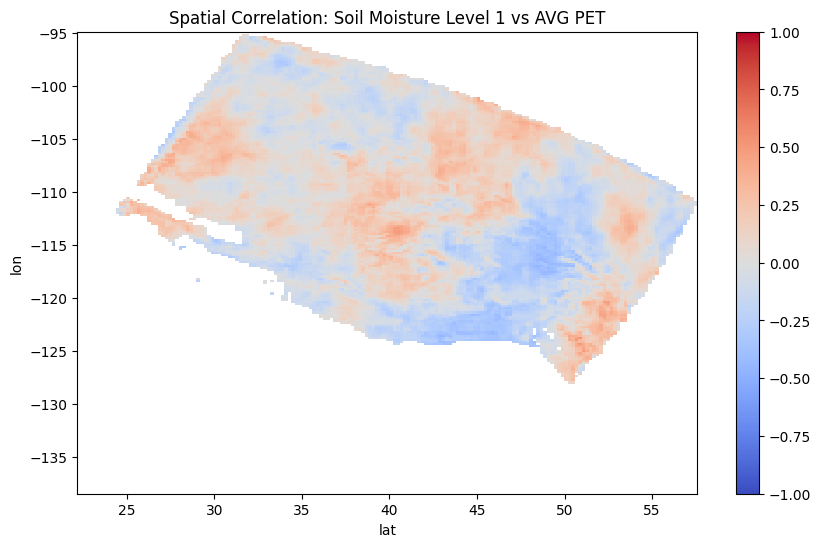

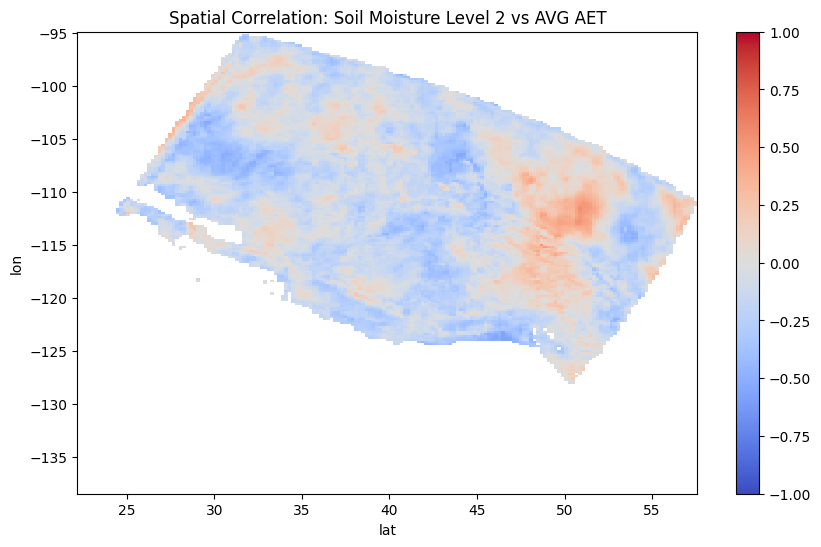

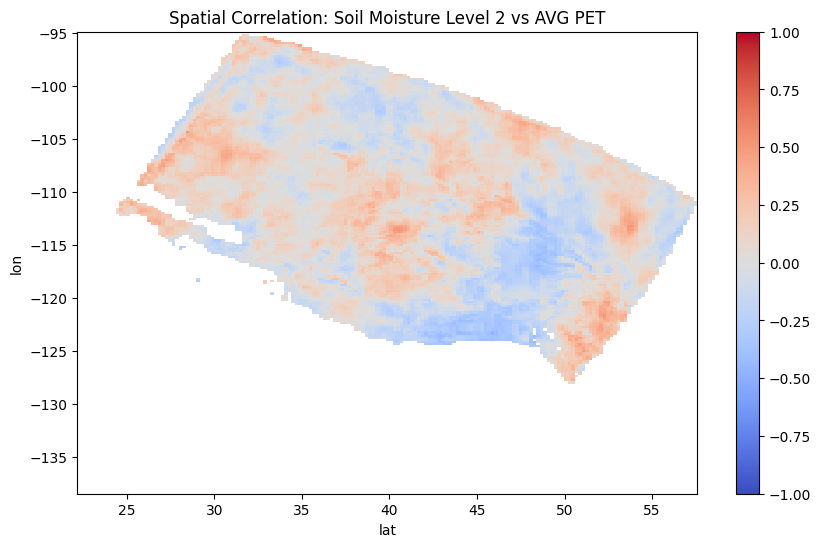

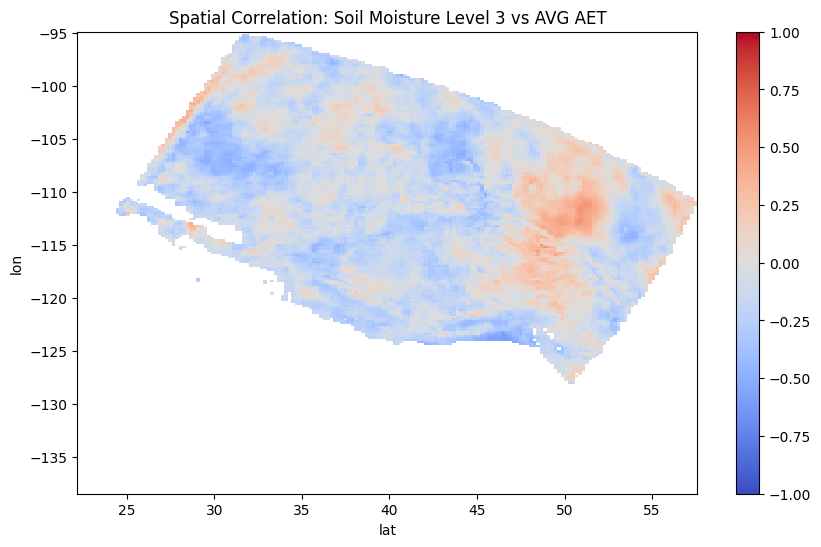

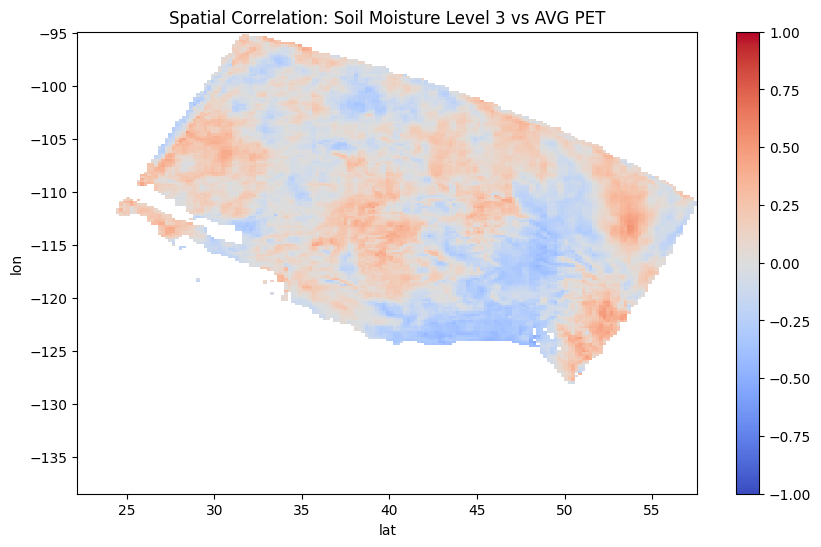

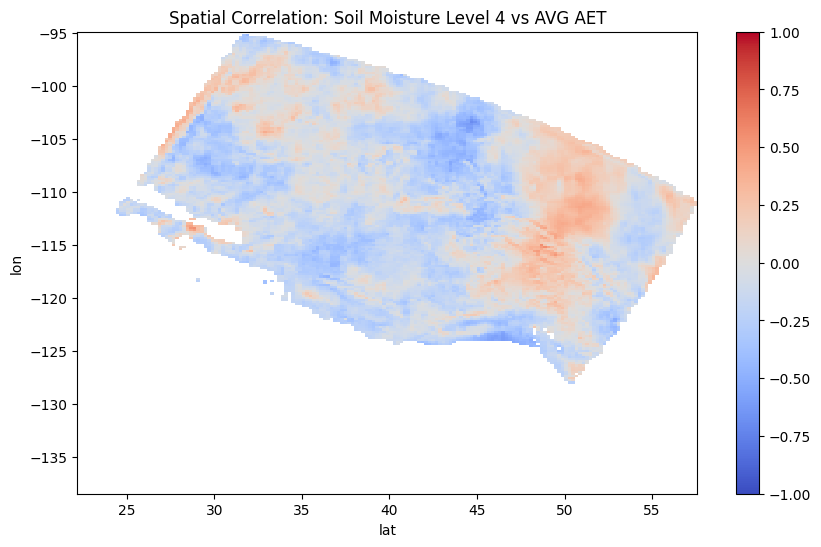

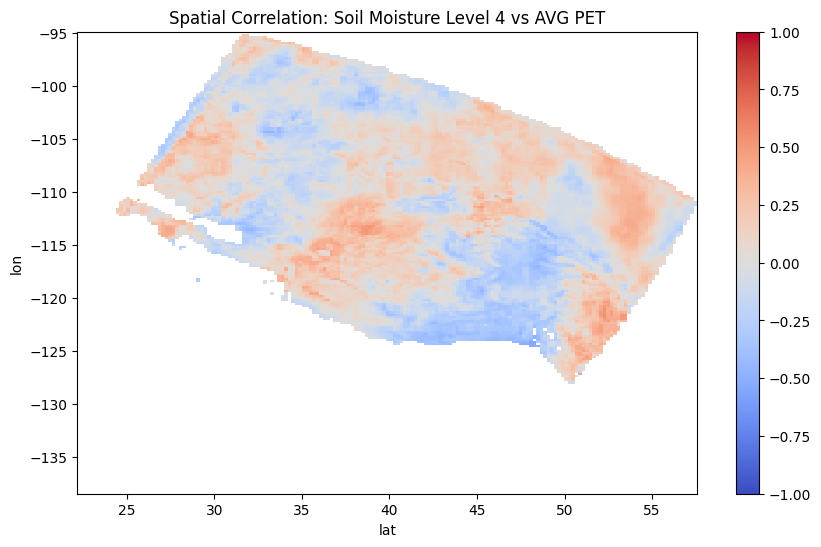

In [191]:
# Define the base ImageCollection for soil moisture
wrf_variable_name = 'soil-moisture'
soil_moisture = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Iterate through the different levels (1, 2, 3, 4) for soil moisture
for level in range(1, 5):
    # Filter the ImageCollection for the specific soil moisture level
    wrf_variable_level = soil_moisture.filter(ee.Filter.eq('soil_m_level', level))

    # Convert to Xarray and calculate the mean over the 'time' dimension
    ds_wrf_sm = xarray.open_dataset(wrf_variable_level, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable_level.first().geometry())
    sm_mean = ds_wrf_sm.mean(dim='time')
    sm_mean = ds_wrf_sm['B0'].rio.write_crs("EPSG:4326")  # Assuming the variable is in 'B0'

    # Compute the correlation between soil moisture mean and AET mean for this level
    corr_sm_aet = xarray.corr(sm_mean, aet_mean, dim='time')

    # Compute the correlation between soil moisture mean and PET mean for this level
    corr_sm_pet = xarray.corr(sm_mean, pet_mean, dim='time')

    # Plot the correlation maps for this soil moisture level
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    corr_sm_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(f"Spatial Correlation: Soil Moisture Level {level} vs AVG AET")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    corr_sm_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(f"Spatial Correlation: Soil Moisture Level {level} vs AVG PET")
    plt.show()


# 90th

In [ ]:
# Load AET and PET
aet_time_series = ds_aet.aet
pet_time_series = ds_pet.pet
aet_time_series = aet_time_series.rio.write_crs("EPSG:4326")
pet_time_series = pet_time_series.rio.write_crs("EPSG:4326")

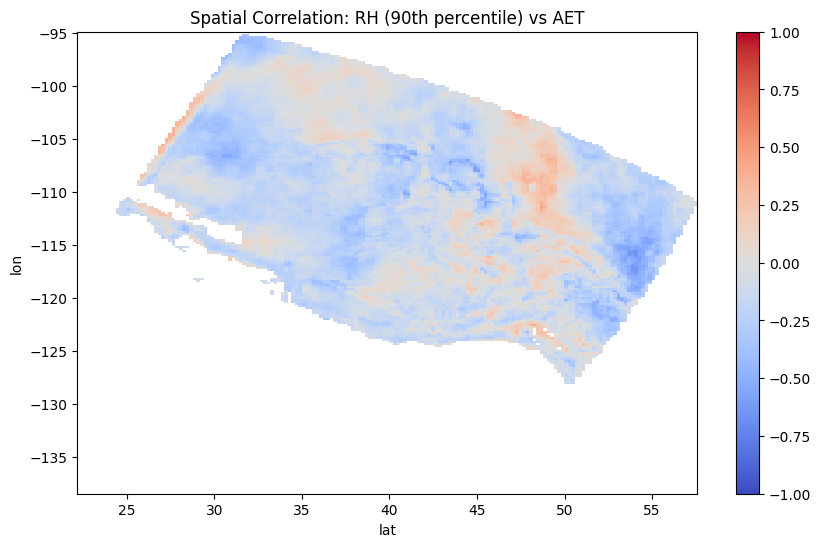

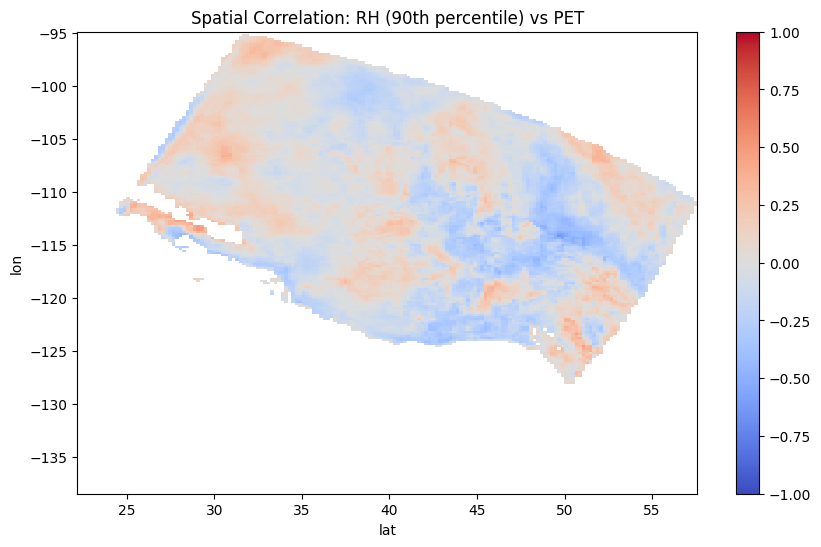

In [193]:
# Define the ImageCollection for relative humidity (p90)
wrf_variable_name = 'relative-humidity-p90'
wrf_variable = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Convert the relative humidity (p90) data to Xarray without calculating the mean
ds_wrf_rh_p90 = xarray.open_dataset(wrf_variable, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())

# Assuming the variable is stored in 'B0', adjust if needed
rh_p90 = ds_wrf_rh_p90['B0'].rio.write_crs("EPSG:4326")



# Compute the correlation between relative humidity (p90) and AET across the 'time' dimension
corr_rh_p90_aet = xarray.corr(rh_p90, aet_time_series, dim='time')

# Compute the correlation between relative humidity (p90) and PET across the 'time' dimension
corr_rh_p90_pet = xarray.corr(rh_p90, pet_time_series, dim='time')

# Plot the correlation maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_rh_p90_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: RH (90th percentile) vs AET")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_rh_p90_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: RH (90th percentile) vs PET")
plt.show()



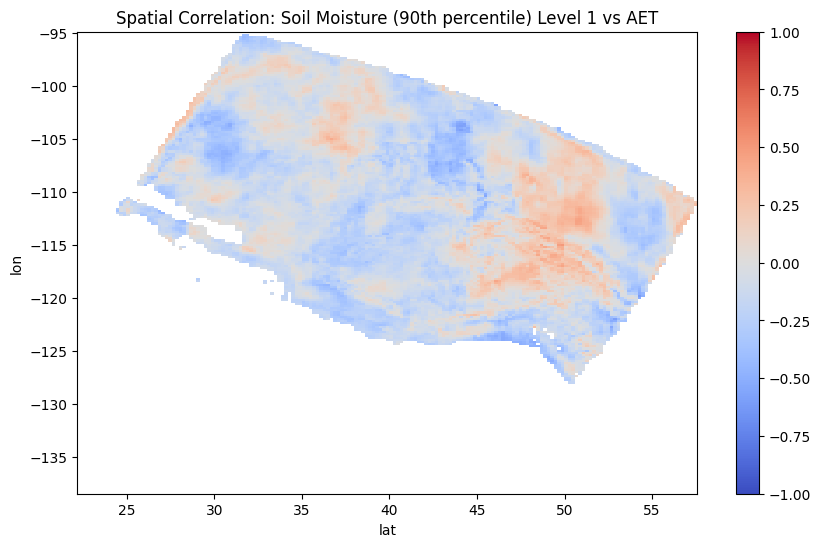

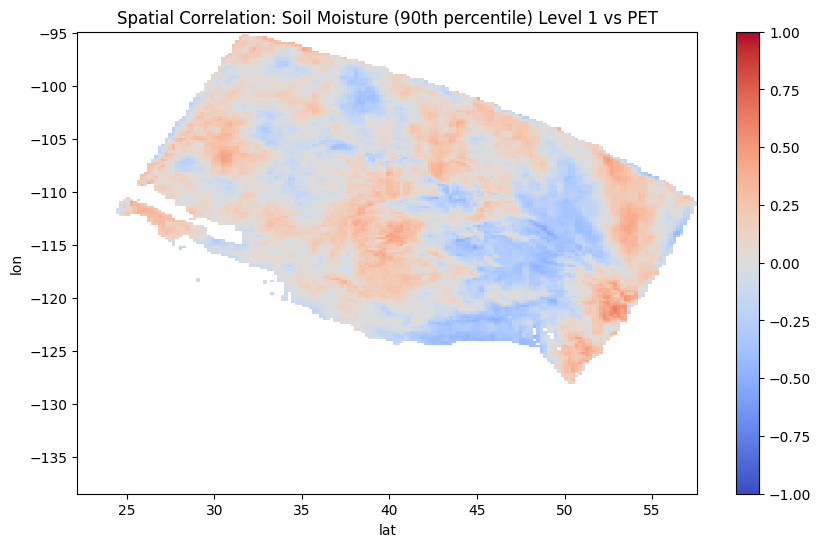

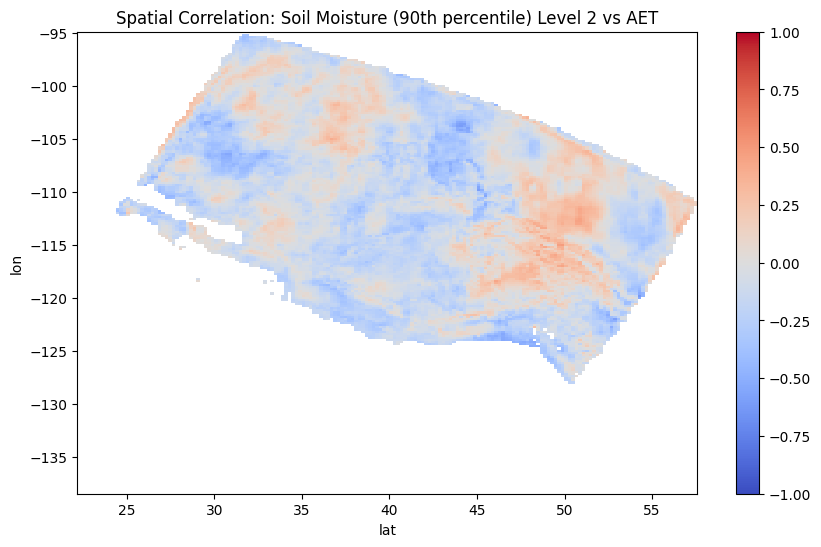

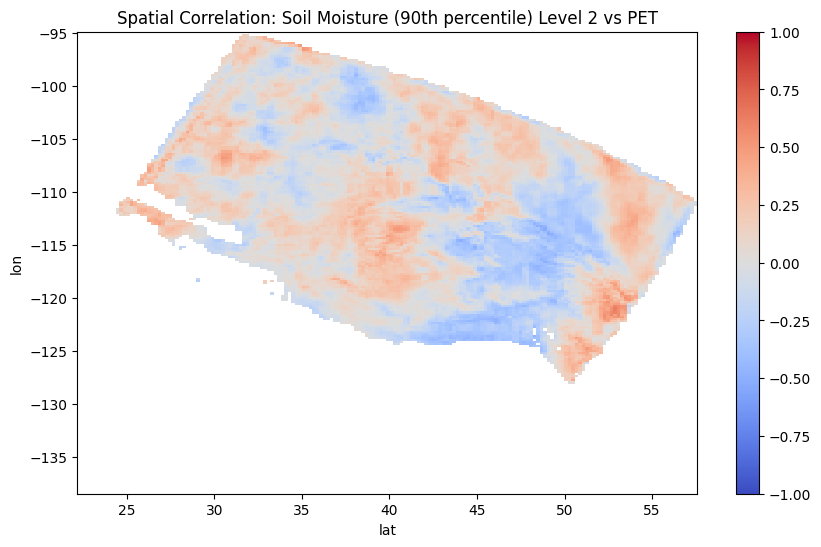

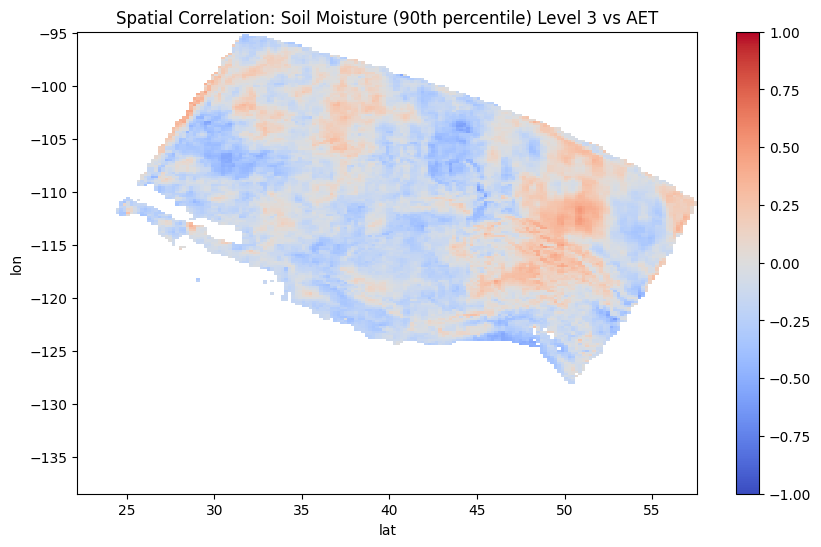

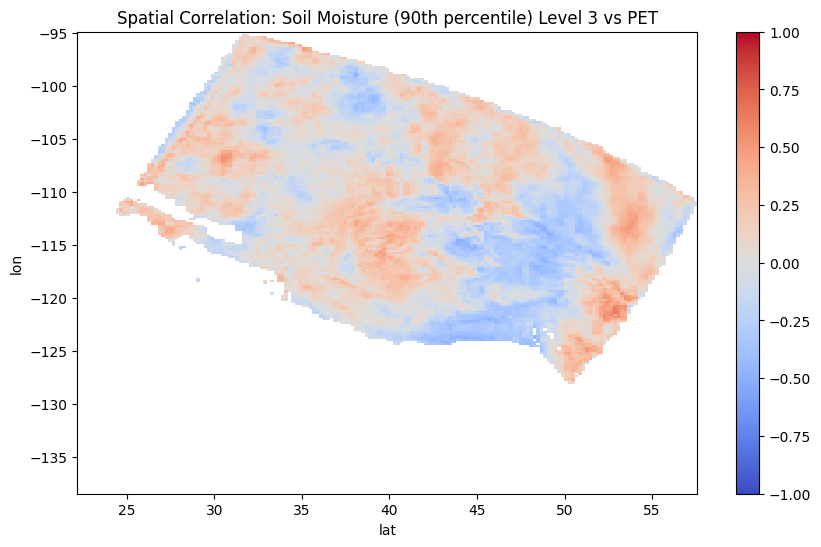

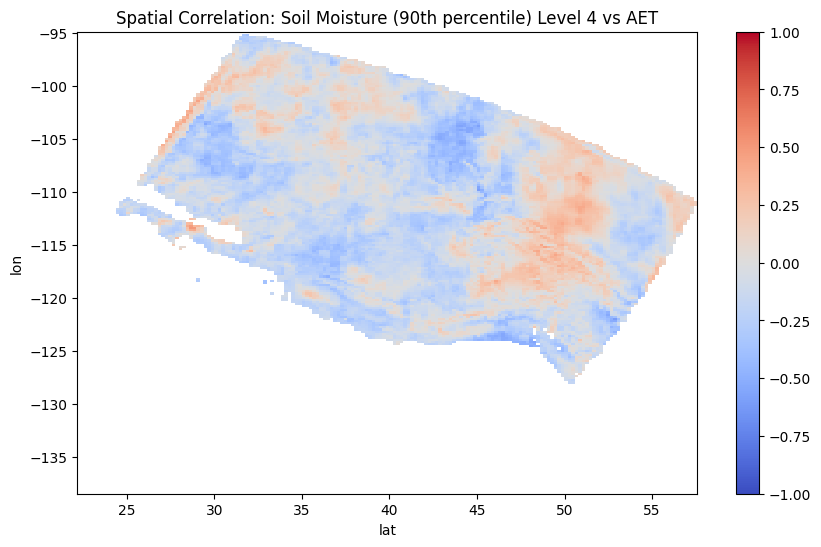

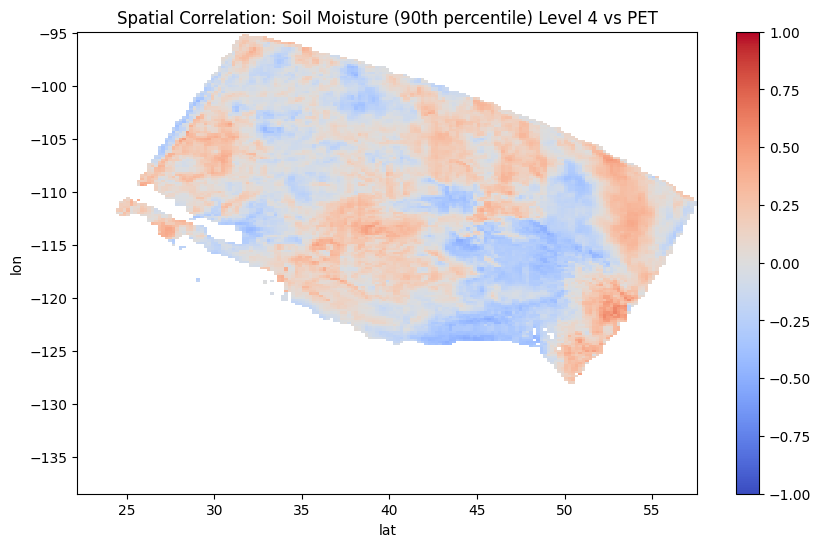

In [194]:
# Define the ImageCollection for soil moisture (p90)
wrf_variable_name = 'soil-moisture-p90'
soil_moisture_p90 = ee.ImageCollection(f'projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}') \
               .filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Iterate through the different levels (1, 2, 3, 4) for soil moisture (p90)
for level in range(1, 5):
    # Filter the ImageCollection for the specific soil moisture level (p90)
    wrf_variable_level_p90 = soil_moisture_p90.filter(ee.Filter.eq('soil_m_level', level))

    # Convert the soil moisture (p90) data to Xarray without calculating the mean
    ds_wrf_sm_p90 = xarray.open_dataset(wrf_variable_level_p90, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable_level_p90.first().geometry())

    # Assuming the variable is stored in 'B0', adjust if needed
    sm_p90 = ds_wrf_sm_p90['B0'].rio.write_crs("EPSG:4326")

    # Compute the correlation between soil moisture (p90) and AET across the 'time' dimension
    corr_sm_p90_aet = xarray.corr(sm_p90, aet_time_series, dim='time')

    # Compute the correlation between soil moisture (p90) and PET across the 'time' dimension
    corr_sm_p90_pet = xarray.corr(sm_p90, pet_time_series, dim='time')

    # Plot the correlation maps for each soil moisture level (p90)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    corr_sm_p90_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(f"Spatial Correlation: Soil Moisture (90th percentile) Level {level} vs AET")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    corr_sm_p90_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(f"Spatial Correlation: Soil Moisture (90th percentile) Level {level} vs PET")
    plt.show()

